# Development Notebook

The purpose of this notebook is to create some standard documentation for new features and checks for validation of GPEC development.


## Setup

In [2]:
%pylab notebook

import sys
if '/p/gpec/users/nlogan/gpec' not in sys.path:
    sys.path.append('/p/gpec/users/nlogan/gpec')
from pypec import data,gpec,post

import seaborn
seaborn.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


## Data

Before doing anything else, I will collect the netcdf outputs for the release's DIII-D example case and confirm the release version for future reference.

In [4]:
kpec_dir = '/p/gpec/GPEC-1.0/docs/examples/DIIID_kinetic_example/'
gpec_dir = '/p/gpec/GPEC-1.0/docs/examples/DIIID_ideal_example/'
ipec_dir = '/p/gpec/GPEC-0.4/docs/examples/DIIID_example/'

In [14]:
gpec_con = data.open_dataset(gpec_dir+'gpec_control_output_n1.nc')
gpec_cyl = data.open_dataset(gpec_dir+'gpec_cylindrical_output_n1.nc')
gpec_prof = data.open_dataset(gpec_dir+'gpec_profile_output_n1.nc')
gpec_pent = data.open_dataset(gpec_dir+'pentrc_output_n1.nc')

kpec_con = data.open_dataset(kpec_dir+'gpec_control_output_n1.nc')
kpec_cyl = data.open_dataset(kpec_dir+'gpec_cylindrical_output_n1.nc')
kpec_prof = data.open_dataset(kpec_dir+'gpec_profile_output_n1.nc')
kpec_pent = data.open_dataset(kpec_dir+'pentrc_output_n1.nc')

print(gpec_con.attrs['version'])
print(gpec_pent.attrs['version'])
print(kpec_con.attrs['version'])
print(kpec_pent.attrs['version'])

GPEC version 1.0.5
GPEC version 1.0.5
GPEC version 1.0.4
GPEC version 1.0.0


## Standard Benchmarks

Here we benchmark both the ideal and kinetic calculations in major release 1 to the purely ideal DCON-IPEC calculations in the last ideal minor release 0.4. We expect the ideal GPEC calculations to match the IPEC calculations well.

### DCON

The DCON results are consistent across versions.

The energy eiegenvalues in version 0.4 are real by definition. The ideal run of version 1.0 returns similar real energy eigenvalues with small-to-zero imaginary componentents. The least stable mode energy is 123% the version 0.4 energy.

Interestingly, the kinetic GPEC 1.0 calaculation returns energy eigenvalues with essentially the same real energy curve (the least stable value is 139% v0.4, 113% v1.0 ideal) but with a consistently order-unity negative imaginary (torque) component. There is one noteable exception in one highly stable eigenmode with order unity *positive* torque. **What is this positive torque mode?**


Calling check_control_matrices

Calling check_energies


<IPython.core.display.Javascript object>


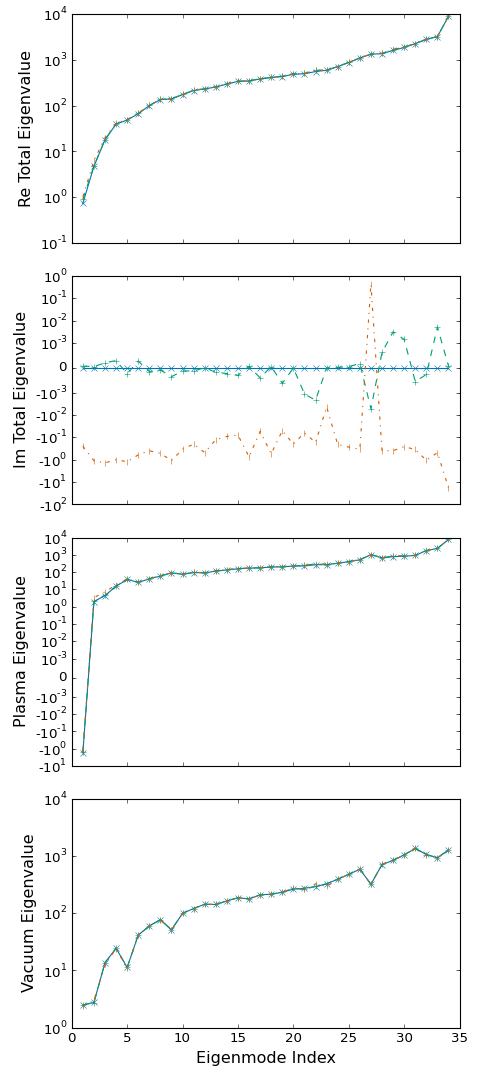


                        /p/gpec/GPEC-0.4/d...   /p/gpec/GPEC-1.0/d...   /p/gpec/GPEC-1.0/d...   
------------------------------------------------------------------------------------------------
total                   +7.3090e-01             +9.0210e-01+7.0180e-05j +1.0170e+00-2.4700e-01j 
plasma                  -1.7540e+00             -1.6000e+00             -1.3260e+00             
vacuum                  +2.4850e+00             +2.5020e+00             +2.3430e+00             


In [40]:
from regression.compare import compare_dcons
reload(compare_dcons)
close('all')

compare_dcons.check_all(ipec_dir,gpec_dir,kpec_dir)

### GPEC 

Here we see some fairly large discrepencies between v0.4 and v1.0 ideal calculations. These are

1. The plasma response seems slightly reduced in v1.0. This is most obvious in the b_n_fun and xi_n_fun, which show the same qualitative shape but are slightly reduced quantitatively.
2. A new scalar normalization of the half-area wieghted field vectors (Phi_xe, Phi_e) and all control surface matrices in this space. This is expected. 
  - Big question: **Should v0.4 be supported with parrallel patches to maintian similar normalization?** The outputs have different naming conventions, which should make anyone switching between them warry enough to pay close attention to the definitions.
3. The energy values are reduced by the above normalization. The energys are really the energys of the unit eigenvectors, and so are normalized by |Phi_xe|^2 (now reduced by area). **Including units for these would clarify this.**
4. The overlap vector amplitudes are reduced. The amplitude of any overlap vector should be the amplitude of the original Phi_xe vector. We confirm this below for version 1.0, but find **the 0.4 release is improperly nromalized**.


We also clearly see the impact of the new kinetic-MHD eiegenvectors from v1.0 DCON.

1. The external field, normalized field, and flux all show a different spectrum than the ideal case. This is because I-coils were added to create a 3x3 coil matrix for torque profile optimization. **Should the ideal example be changed to include I+C coils?** This would make a one-to-one comparison between ideal-kinetic but break the one-to-one benchmark with v0.4 unless we begin supporting v0.4 with parallel pathces.

('-', '/p/gpec/GPEC-0.4/docs/examples/DIIID_example/')


<IPython.core.display.Javascript object>


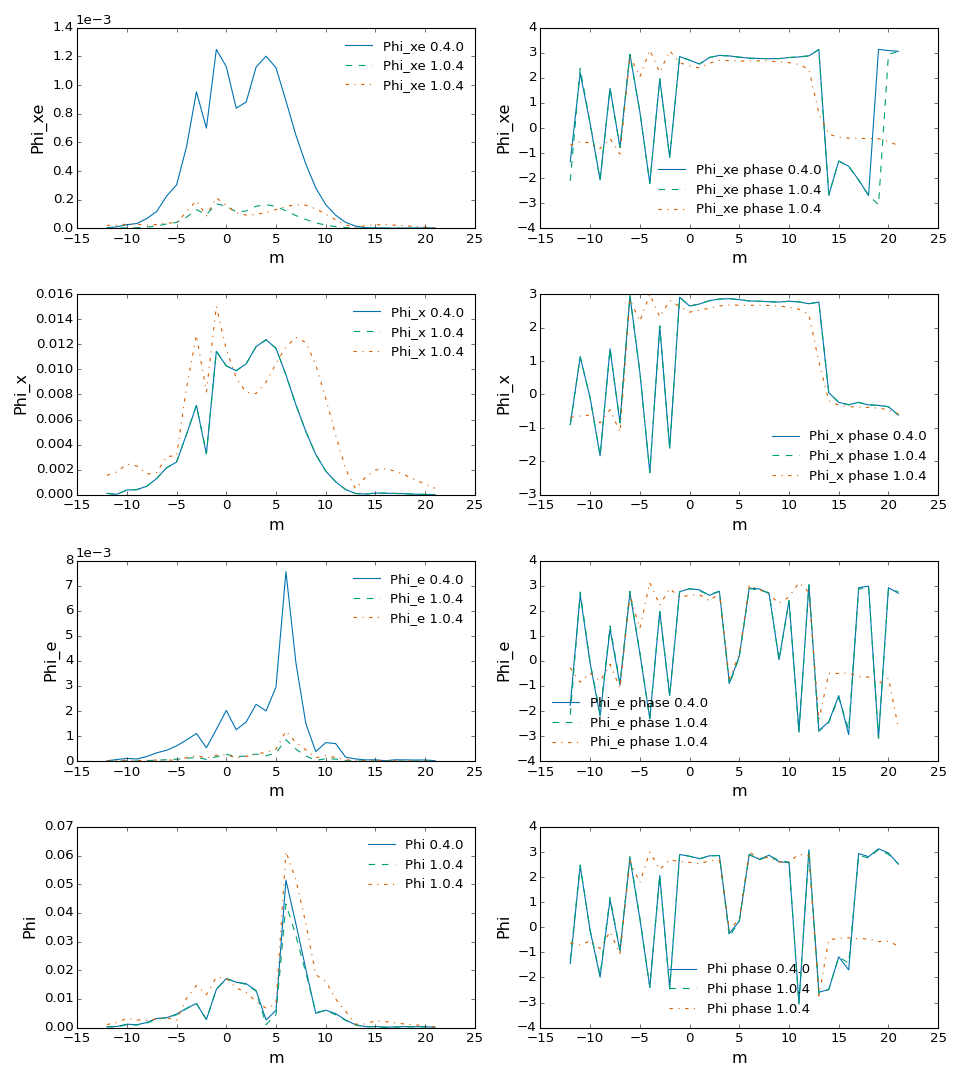

<IPython.core.display.Javascript object>


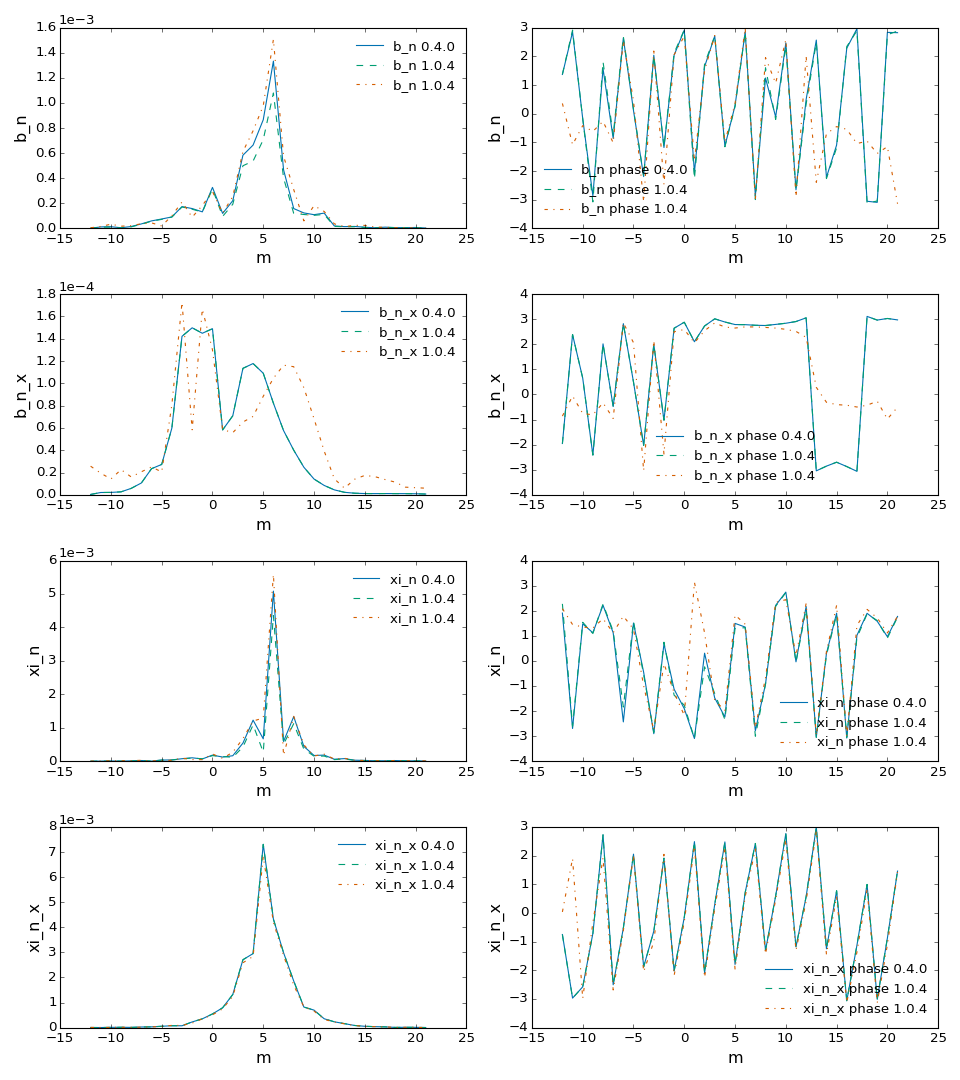

<IPython.core.display.Javascript object>


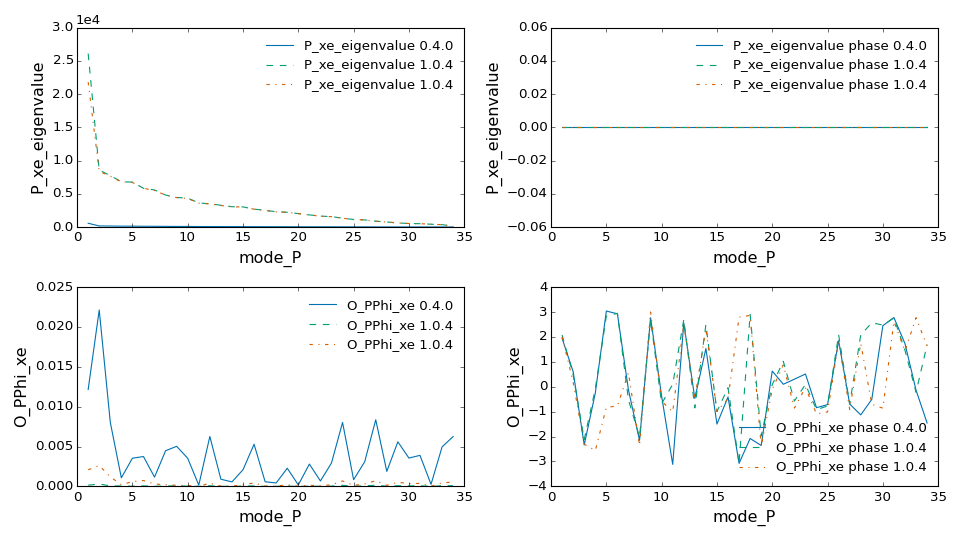

<IPython.core.display.Javascript object>


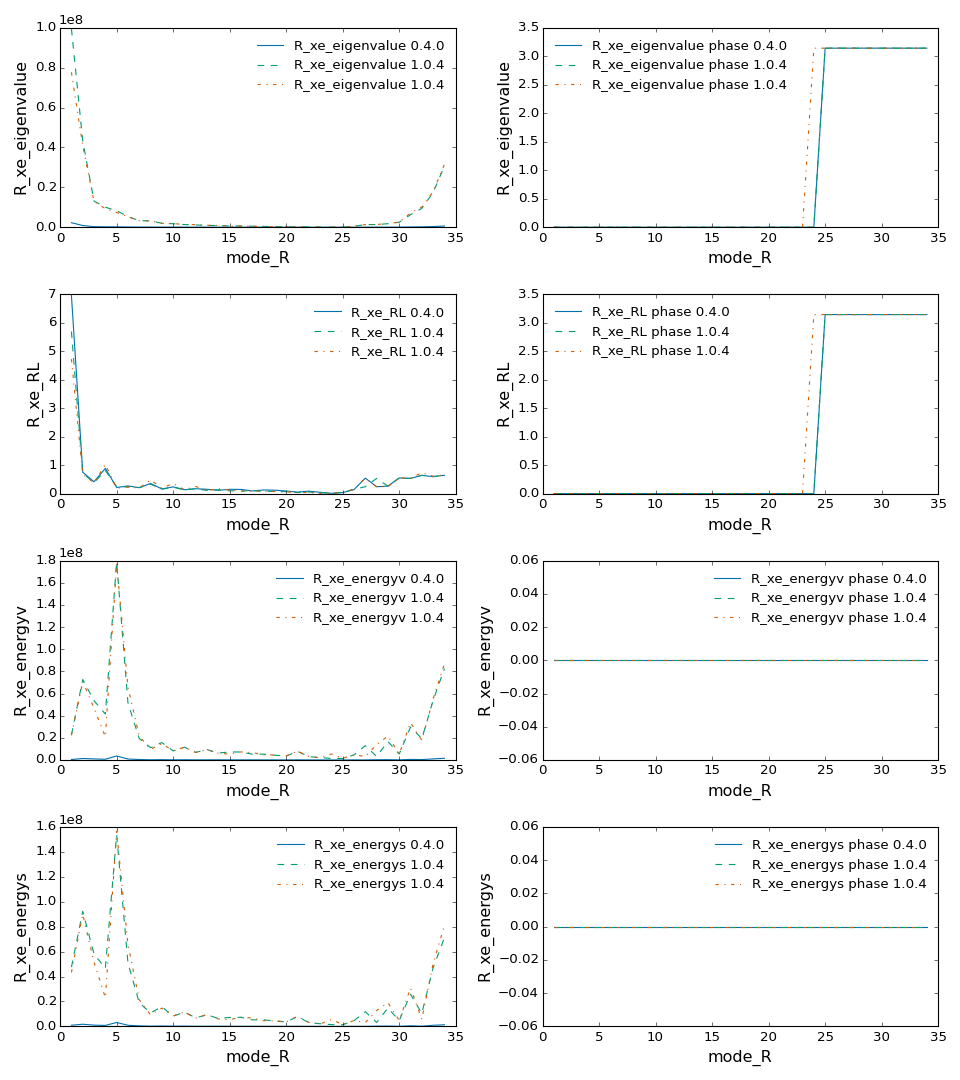

<IPython.core.display.Javascript object>


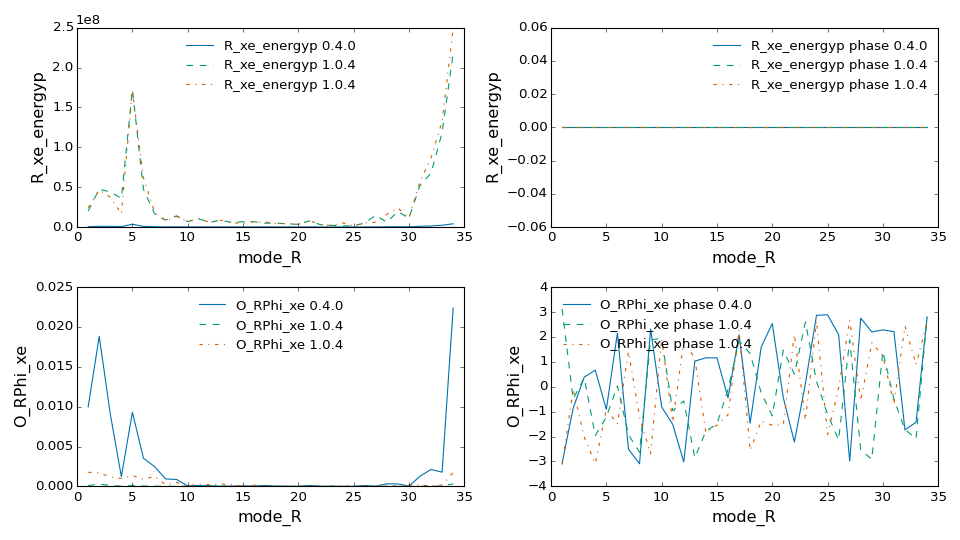

<IPython.core.display.Javascript object>


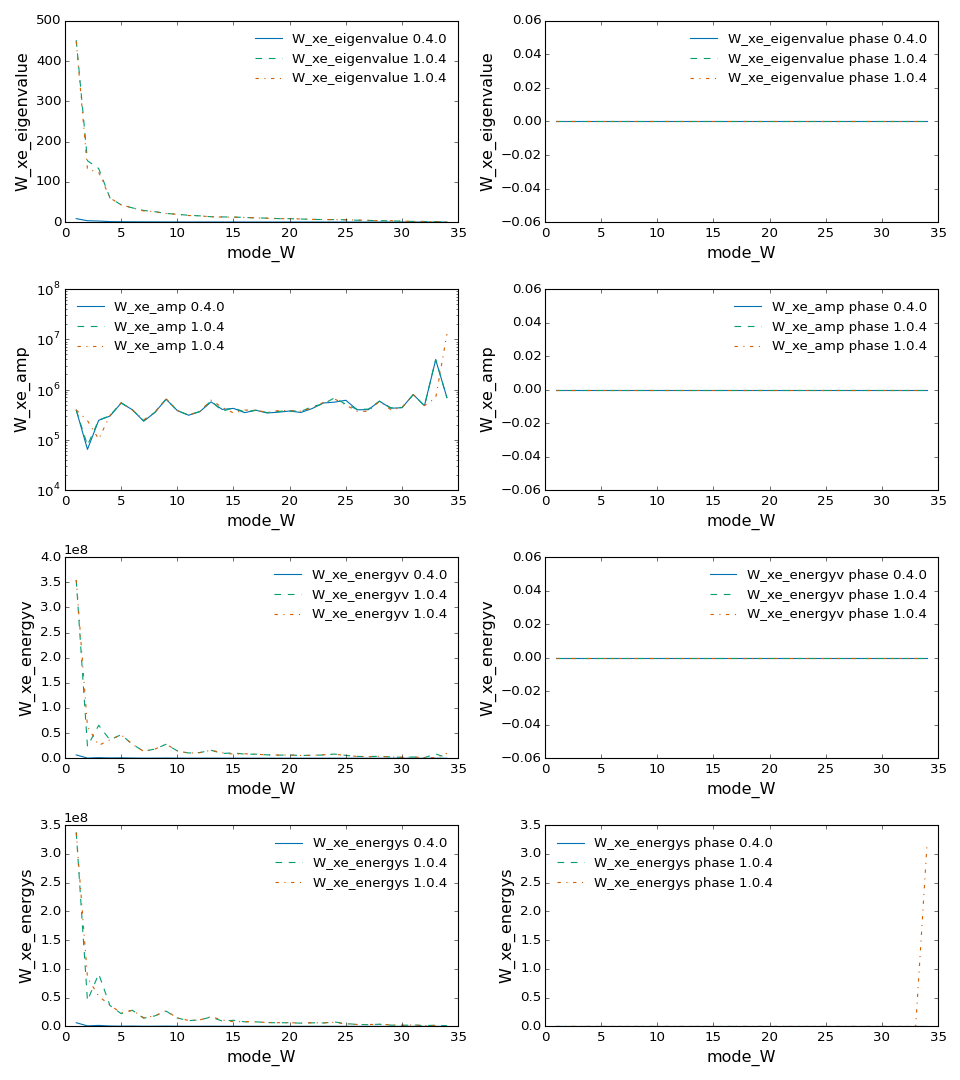

<IPython.core.display.Javascript object>


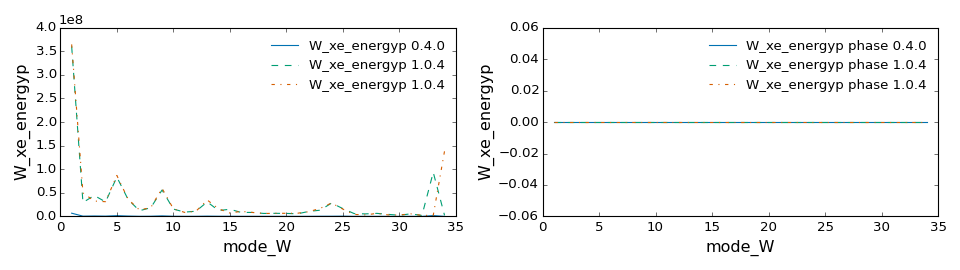

<IPython.core.display.Javascript object>


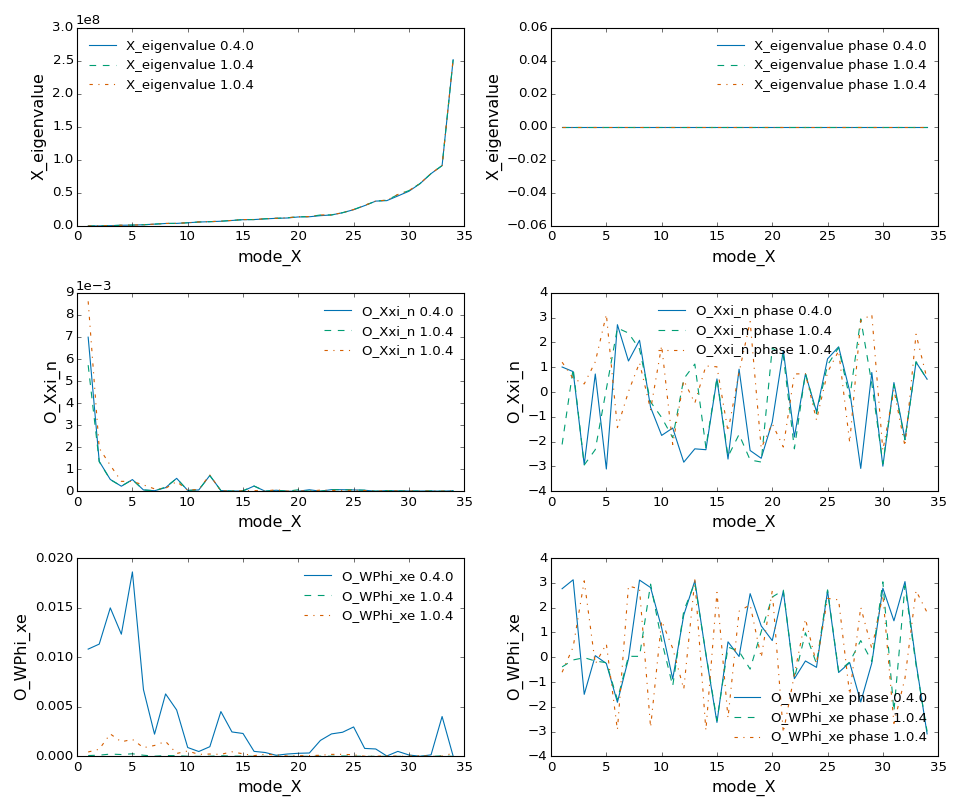

<IPython.core.display.Javascript object>


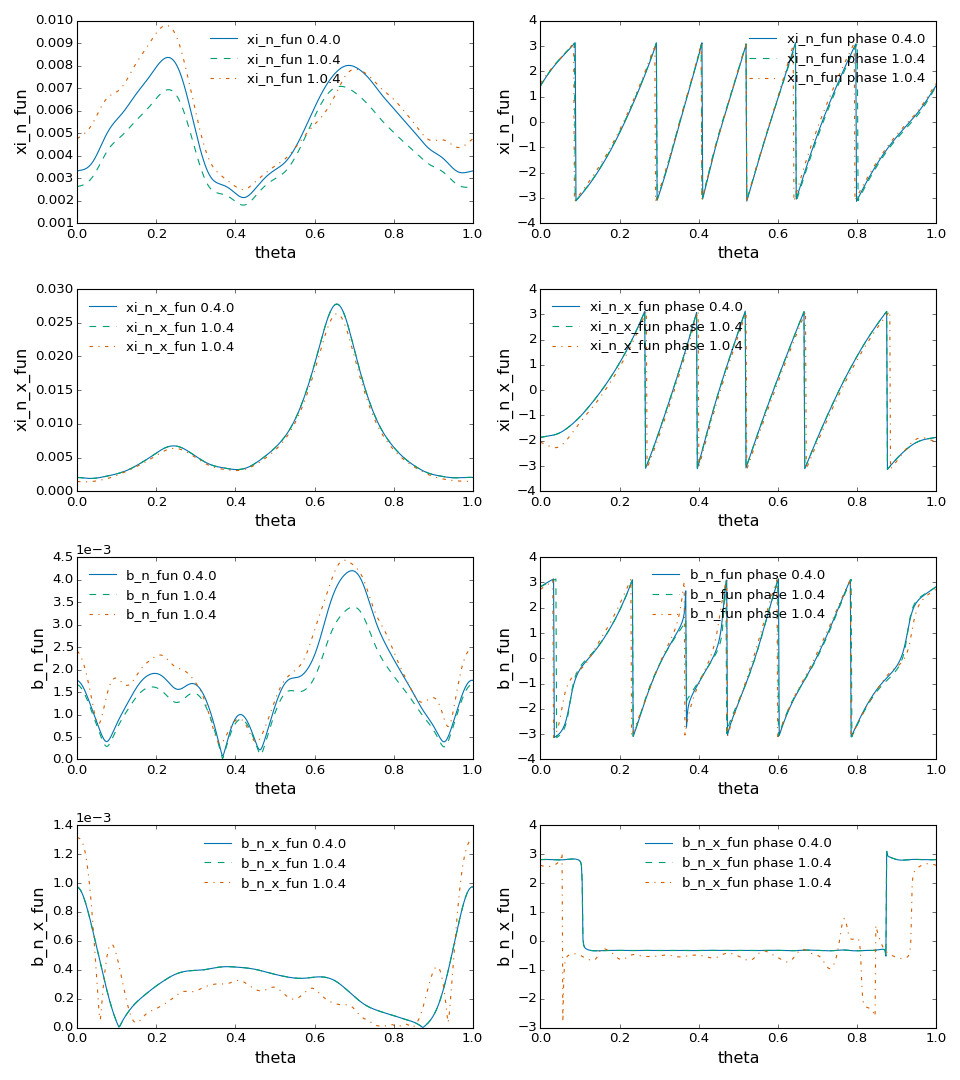

<IPython.core.display.Javascript object>


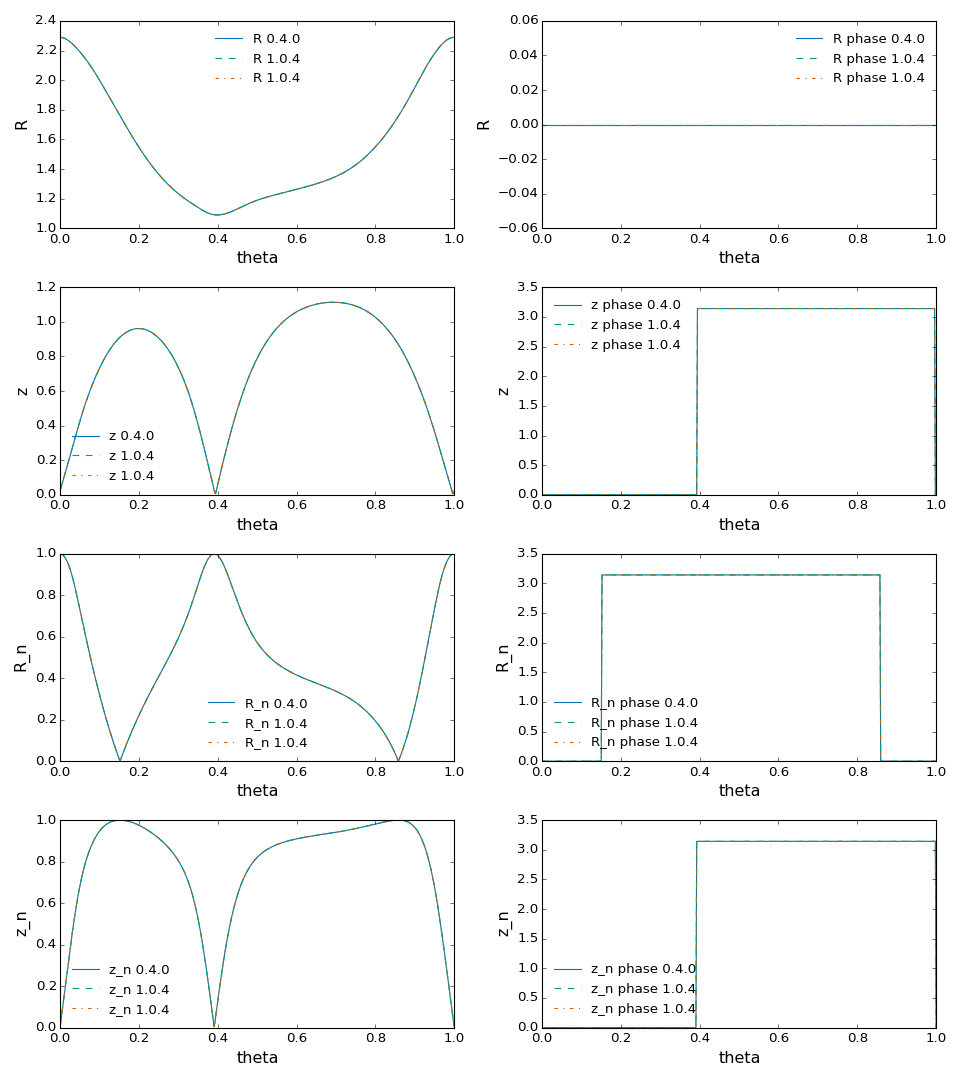

<IPython.core.display.Javascript object>


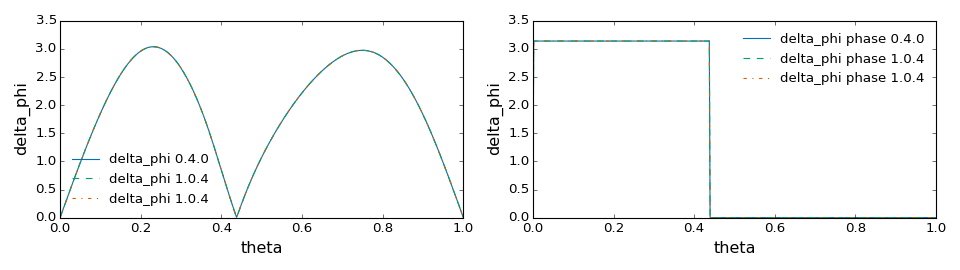

('--', '/p/gpec/GPEC-1.0/docs/examples/DIIID_ideal_example/')
('-.', '/p/gpec/GPEC-1.0/docs/examples/DIIID_kinetic_example/')


Area = 5.291e+01
Sqrt = 7.274e+00


Self consistency of overlap norm

Key                      GPEC-0.4         GPEC-1.0
---------------------------------------------------
O_WPhi_xe               9.935e+00        1.000e+00
O_PPhi_xe               9.935e+00        1.000e+00
O_RPhi_xe               9.935e+00        1.000e+00


In [51]:
from regression.compare import compare_gpecs
reload(compare_gpecs)
close('all')

gpec_data = compare_gpecs.check_control_1d(ipec_dir,gpec_dir,kpec_dir)

print("\n\nArea = {:.3e}".format(gpec_data[1].attrs['area']))
print("Sqrt = {:.3e}".format(np.sqrt(gpec_data[1].attrs['area'])))

print("\n\nSelf consistency of overlap norm (should be 1.0): \n")
print("{:16} {:>16} {:>16}\n".format('Key','GPEC-0.4','GPEC-1.0')+"-"*17*3)
for k in ['W', 'P', 'R']:
    v0 = np.linalg.norm(gpec_data[0]['O_'+k+'Phi_xe'])/np.linalg.norm(gpec_data[0]['Phi_xe'])
    v1 = np.linalg.norm(gpec_data[1]['O_'+k+'Phi_xe'])/np.linalg.norm(gpec_data[1]['Phi_xe'])
    print("{:16} {:16.3e} {:16.3e}".format('O_'+k+'Phi_xe', v0, v1))

### PENTRC 

We immediately see the pentrc torque has changed.

In the v1.0 ideal example, the FGAR result is 22x the v0.4 one and the TGAR result is 30x the v0.4 one. These are very different from one another. 

What is up??

<IPython.core.display.Javascript object>


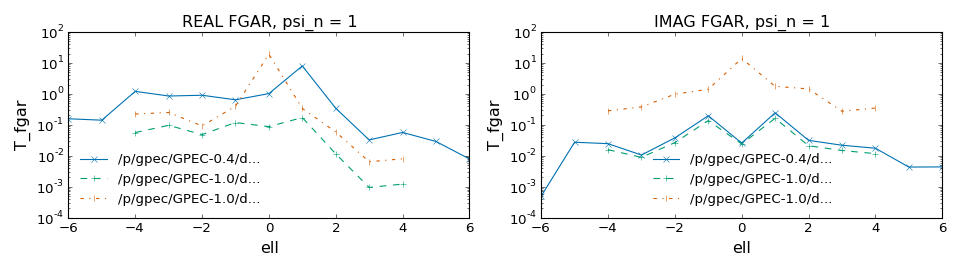


Value                   /p/gpec/GPEC-0.4/d...   /p/gpec/GPEC-1.0/d...   /p/gpec/GPEC-1.0/d...   
------------------------------------------------------------------------------------------------
T_fgar                  1.3349e+01+1.2376e-01j  5.9060e-01+9.4669e-02j  2.0418e+01-1.3122e+01j  

FGAR


<IPython.core.display.Javascript object>


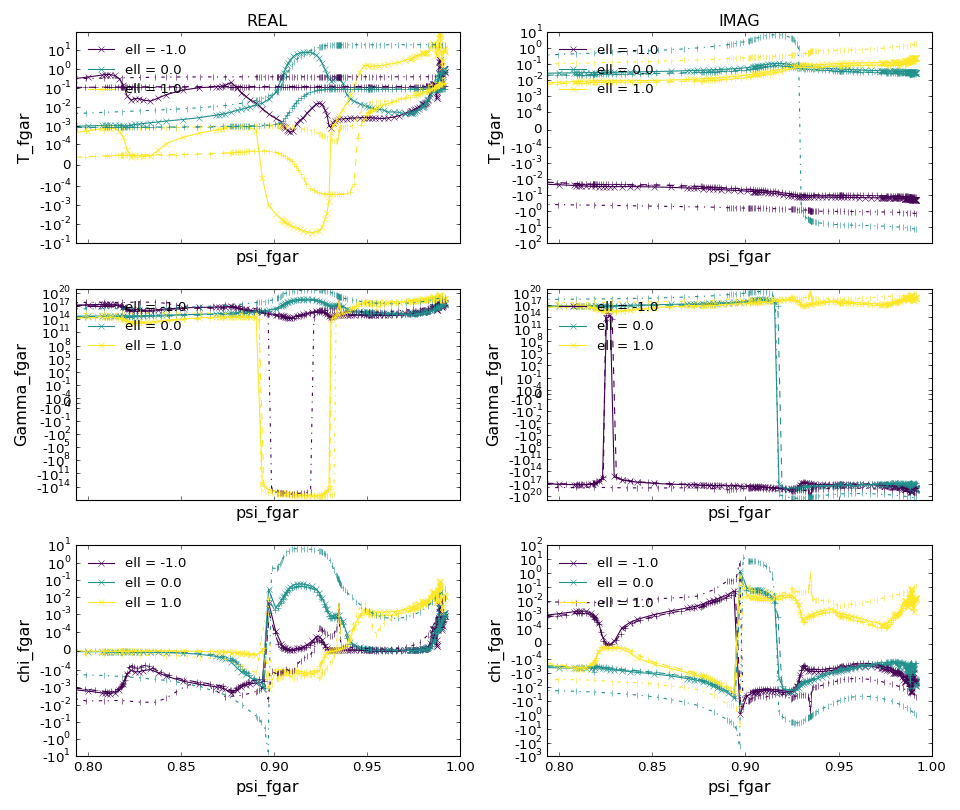

- x /p/gpec/GPEC-0.4/docs/examples/DIIID_example/
-- + /p/gpec/GPEC-1.0/docs/examples/DIIID_ideal_example/
-. | /p/gpec/GPEC-1.0/docs/examples/DIIID_kinetic_example/


In [60]:
from regression.compare import compare_pentrcs
reload(compare_pentrcs)
close('all')

#pentrc_data = compare_pentrcs.check_all(ipec_dir,gpec_dir,kpec_dir)
pentrc_data = compare_pentrcs.check_integrals(ipec_dir,gpec_dir,kpec_dir)
pentrc_data = compare_pentrcs.check_profiles(ipec_dir,gpec_dir,kpec_dir)



## Self Consistency Checks


In the kinetic versions of GPEC, we can calculate the torque from the surface term, from a number of internal matrices in the perturbed equilibrium calculation, and from the PENTRC code using the perturbed displacements. These methods are expected to be self consistent in the perturbed equilibrium limit when the numerical treatment has been handled correctly.

What we see is that the GPEC torque profile and matrices are self consistent, but inconsistent with the PENTRC profile.


<IPython.core.display.Javascript object>


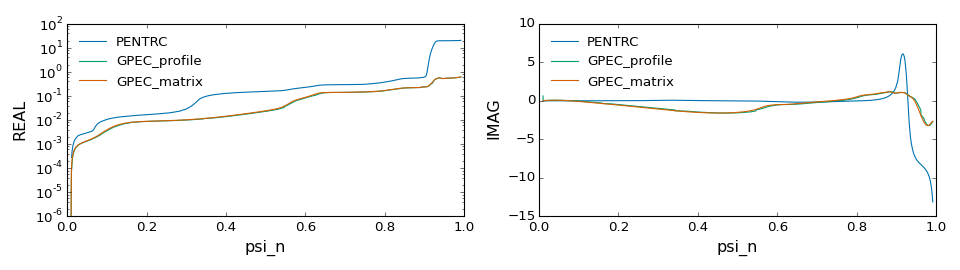

                  Method                    Total         Fractional-Error
---------------------------------------------------------------------------
                  PENTRC     2.042e+01-1.312e+01j             0.000+0.000j
            GPEC_profile     6.244e-01-2.703e+00j             0.969+0.794j
             GPEC_matrix     6.248e-01-2.643e+00j             0.969+0.799j


False

In [12]:
from regression.test import surface_torque
reload(data)
data.plt.seaborn.set_palette('colorblind')
reload(surface_torque)

surface_torque.check(loc=kpec_dir)


We see that our results are not self consistent.

To figure out why, we start by checking that the torque matrices look regular.

They do show many of the expected characteristics. They show a stong self-coupling m=m_prime line, strong coupling to the low m that penetrate deep into the plasam, and the characteristic kink-coupling plume at m,m_prime>n\*q_lim. 


<IPython.core.display.Javascript object>


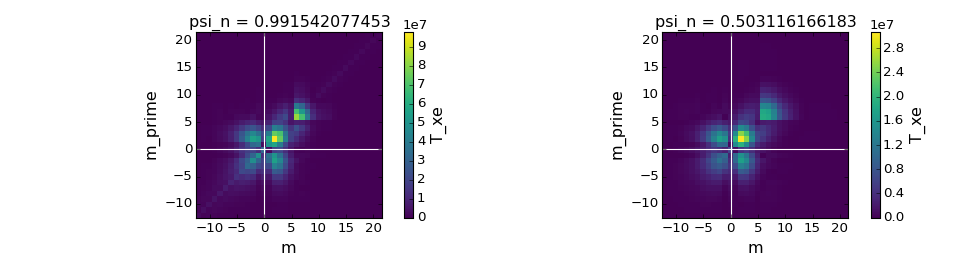

In [15]:
f,ax = data.plt.subplots(1,2,subplot_kw={"aspect":"equal"})
im = np.abs(kpec_prof['T_xe'].sel(psi_n=1,method='nearest')).plot(ax=ax[0])
im = np.abs(kpec_prof['T_xe'].sel(psi_n=0.5,method='nearest')).plot(ax=ax[1])
for a in ax.flat:
    a.axvline(0,color='w')
    a.axhline(0,color='w')
